In [1]:
dataset_name = "exchange-2_cpm_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import math
import numpy as np
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
data = data.dropna()
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

# if you want to use a method that cannot take missing time steps
# into account, you need to fill in the missing time steps yourself
# this function also removes duplicates
print("Fill Missing Time Steps with Interpolation")
data = adclasses.fill_missing_time_steps(start_date, end_date, '1H', data, method="linear")

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-26 06:00:01",
                      "2011-08-10 17:00:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:00:01
End date:  2011-09-07 15:00:01
Missing time stamps: 
 DatetimeIndex(['2011-07-21 05:00:01', '2011-08-08 18:00:01',
               '2011-08-10 16:00:01', '2011-08-15 22:00:01',
               '2011-08-15 23:00:01', '2011-09-01 19:00:01',
               '2011-09-01 20:00:01', '2011-09-01 21:00:01',
               '2011-09-01 22:00:01', '2011-09-01 23:00:01',
               '2011-09-02 00:00:01', '2011-09-02 01:00:01',
               '2011-09-02 02:00:01', '2011-09-02 03:00:01',
               '2011-09-02 04:00:01', '2011-09-02 05:00:01',
               '2011-09-02 06:00:01', '2011-09-02 07:00:01',
               '2011-09-02 08:00:01', '2011-09-02 09:00:01',
               '2011-09-02 10:00:01', '2011-09-02 11:00:01',
               '2011-09-02 12:00:01', '2011-09-02 13:00:01',
               '2011-09-02 14:00:01'],
              dtype='datetime64[ns]', freq=None)
Fill Missing Time Steps with Interpolation
Duplicate records found: 
                        

# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

100%|██████████| 1648/1648 [00:00<00:00, 15924.78it/s]

Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1648/1648 [00:00<00:00, 14064.79it/s]

eta:  0.5
lambda:  0.99
MSE:  0.007375941379405463
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1648/1648 [00:00<00:00, 13183.25it/s]

eta:  0.5
lambda:  0.999
MSE:  0.008511985660160756
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1648/1648 [00:00<00:00, 17337.40it/s]

eta:  0.5
lambda:  0.9999
MSE:  0.008749757890510737
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1648/1648 [00:00<00:00, 17512.35it/s]

eta:  1
lambda:  0.99
MSE:  0.006768001629759531
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1648/1648 [00:00<00:00, 15076.93it/s]

eta:  1
lambda:  0.999
MSE:  0.007587227316301499
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033


eta:  1
lambda:  0.9999
MSE:  0.007810413546597199

best params:  eta 1 lambda 0.99


100%|██████████| 1648/1648 [00:00<00:00, 14777.96it/s]

Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033


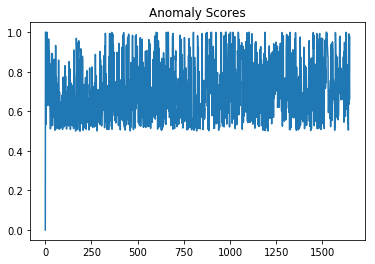

Time:  0.4528028964996338


['anomaly_scores/GLM/exchange-2_cpm_results']

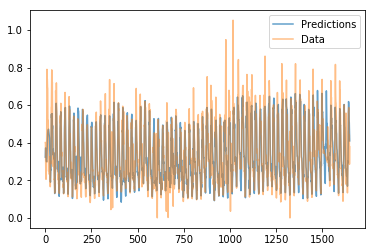

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)


# Anomalous

In [6]:
# only need one window size

# save_path = "anomaly_scores/anomalous/" + dataset_name
# output_dict = ad.anomalous(ts_length=100,
#                            upper=(.2/100) * ad.get_length(),
#                            plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -763.0621
 Regression with ARIMA(0,1,0) errors : -745.4958
 Regression with ARIMA(1,1,0) errors : -749.2606
 Regression with ARIMA(0,1,1) errors : -776.4126
 ARIMA(0,1,0)                    : -748.0604
 Regression with ARIMA(1,1,1) errors : -752.937
 Regression with ARIMA(0,1,2) errors : -783.3701
 Regression with ARIMA(1,1,2) errors : -772.7367
 Regression with ARIMA(0,1,3) errors : -776.7657
 Regression with ARIMA(1,1,3) errors : -758.9351
 ARIMA(0,1,2)                    : -790.006
 ARIMA(0,1,1)                    : -782.2595
 ARIMA(1,1,2)                    : -784.4435
 ARIMA(0,1,3)                    : -785.2716
 ARIMA(1,1,1)                    : -772.8945
 ARIMA(1,1,3)                    : -781.428

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,2)                    : -796.2286

 Best model: Regression with ARIMA(0,1,2) errors 



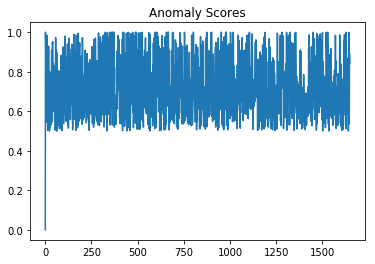

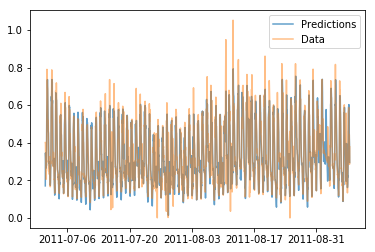

Time:  13.229852437973022


['anomaly_scores/SARIMA_auto/exchange-2_cpm_results']

In [7]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [8]:

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029445466908628653


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002062177942340197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012692914795405037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0010976583007933174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010566062374957976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0033759948090335895


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.002090631595148138


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.001459463004410325


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013698163330831605


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013443413654902288


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.002889870265022071


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0020356575168393384


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012557091052227114


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011074280981775448


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001062826178360801


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003438939855928859


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0021372157526440565


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014795388743810152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013760838027459404


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013415976390877488


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0028682184534652333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002095218648821275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012803749928069772


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.001115446875346828


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001063453504441447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0033969133575415932


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.001966036025611561


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014937140861258612


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013749019254006142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013462502688451478


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029149050114240676


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.001993630221557181


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001256320327113163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.001114979148561517


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010605134826374523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003406276542200177


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0022010930917270573


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014695671594684508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013649665397191101


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013419888783065077


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.002910133233002214


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.001926310927171552


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012701355988537935


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011115457231813239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010634033231679482


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003364569221831428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0021924545054500793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014522036458602572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013656928806217163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013611283145744829


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029445466908628653


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002062177942340197


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012692914795405037


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0010976583007933174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010566062374957976


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0033759948090335895


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.002090631595148138


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.001459463004410325


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013698163330831605


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013443413654902288


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.002889870265022071


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0020356575168393384


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012557091052227114


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011074280981775448


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001062826178360801


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003438939855928859


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0021372157526440565


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014795388743810152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013760838027459404


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013415976390877488


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0028682184534652333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002095218648821275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012803749928069772


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.001115446875346828


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001063453504441447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0033969133575415932


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.001966036025611561


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014937140861258612


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013749019254006142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013462502688451478


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029149050114240676


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.001993630221557181


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001256320327113163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.001114979148561517


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010605134826374523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003406276542200177


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0022010930917270573


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014695671594684508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013649665397191101


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013419888783065077


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.002910133233002214


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.001926310927171552


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012701355988537935


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011115457231813239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010634033231679482


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003364569221831428


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0021924545054500793


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014522036458602572


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013656928806217163
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013611283145744829

best params:  Step Size 100 Seasonality Prior Scale 1 Seasonality Mode additive Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


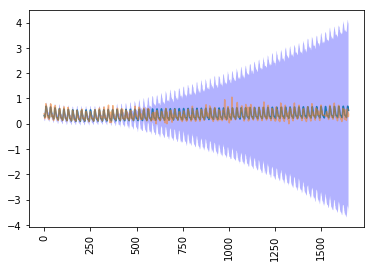

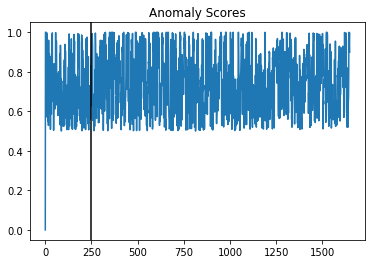

Time:  17.375044107437134


['anomaly_scores/Prophet/exchange-2_cpm_results']

In [9]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=1,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Twitter AD

In [10]:
# only need one window size

# save_path = "anomaly_scores/Twitter/" + dataset_name
# output_dict = ad.twitterad(period=24,max_anoms=((.2/100) * ad.get_length())/ad.get_length(), direction='both', alpha=.001, plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# HTM

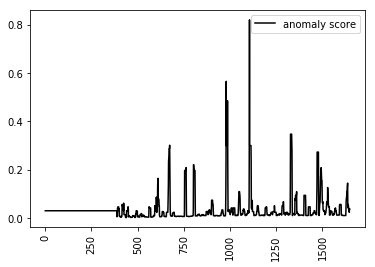

Time:  12.4


['anomaly_scores/HTM/exchange-2_cpm_results']

In [11]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", 12.4)
output_dict = {"Anomaly Scores": anomaly_scores, "Time": 12.4}
joblib.dump(output_dict, save_path)

# STL Resid

In [12]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11283500819397278
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11326598901534908
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11280257285345
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11283500819397278
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11279073135783622
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11281245958622607
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
ou

R stlplus completed: 247 no missing True
STL Resid Sum:  0.1385602210317642
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.25054399312509146
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2516763005483774
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.25017854838342257
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.25054399312509146
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2499775457255982
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.25

R stlplus completed: 247 no missing True
STL Resid Sum:  0.08538042403151284
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.08537579298777194
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.21824996133195282
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.21917802758771782
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2180133163833572
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.21824996133195282
swindow:  periodic
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.217877

R stlplus completed: 247 no missing True
STL Resid Sum:  4.6967415557619646e-05
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  3.427983133818161e-05
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  4.341173732632653e-05
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17620215163862232
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17689727478828518
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17607924117953794
swindow:  periodic
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.1722169623094573
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17221144546720443
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.172235508619108
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1722058484513802
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0689646590258262
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.067073961993504
swindow:  5
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0698264198764825
swindow:  5
s

R stlplus completed: 247 no missing True
STL Resid Sum:  0.08744161525727218
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.08856557427270398
swindow:  5
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.08816645192272302
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14454298168668708
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14285604138386485
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1443556937241342
swindow:  5
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14454298168668708
swindow:  5
sdegree:  0
tw

R stlplus completed: 247 no missing True
STL Resid Sum:  0.03766748870995582
swindow:  5
sdegree:  1
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.03750233686582005
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09927640026506666
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09848332780711182
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09972392904162472
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09927640026506666
swindow:  5
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0997823654861628
swindow:  5
sdegree:  1
twindo

R stlplus completed: 247 no missing True
STL Resid Sum:  3.0368445491147573e-06
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.012502800491148547
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.011542449392368759
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.013012114779943134
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.012502800491148547
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.013078896543626132
swindow:  5
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.012876296145525056
swindow:  5
sdegree:

R stlplus completed: 247 no missing True
STL Resid Sum:  0.09161694783218569
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0905104783880055
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09206840872085092
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09161694783218569
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09212442333038964
swindow:  7
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09197277652700817
swindow:  7
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.09146909162078505
swindow:  7
sdegree:  0
twindo

R stlplus completed: 247 no missing True
STL Resid Sum:  0.19558973796217433
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.19589625187035825
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.19550665803056308
swindow:  7
sdegree:  0
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.19569234308549846
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1833670653694848
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.18212490193655845
swindow:  7
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.18393499476420738
swindow:  7
sdegree:  0


R stlplus completed: 247 no missing True
STL Resid Sum:  0.15041226990771261
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.150151938394751
swindow:  7
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15038668353875623
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14926187624274628
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14860018500255104
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14938037001150803
swindow:  7
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.14926187624274628
swindow:  7
sdegree:  1
twindow

R stlplus completed: 247 no missing True
STL Resid Sum:  0.07154047673421121
swindow:  7
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.07135440869268382
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.07105480075637975
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0700230476329906
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.07149361099371834
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.07105480075637975
swindow:  7
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.07157286724817086
swindow:  7
sdegree:  2
twindo

R stlplus completed: 247 no missing True
STL Resid Sum:  0.10341029685132097
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1029788688475914
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10246121223435103
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10327647727548916
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1029788688475914
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10333834246194903
swindow:  9
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10318776308084626
swindow:  9
sdegree:  0
twindow

R stlplus completed: 247 no missing True
STL Resid Sum:  0.2063894392925793
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.20524841202581423
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2072628130243727
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.2063894392925793
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.20743464955639845
swindow:  9
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.20699175386176744
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15752044912044516
swindow:  9
sdegree:  0
tw

R stlplus completed: 247 no missing True
STL Resid Sum:  0.17401241024240005
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17381731115965324
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17374895993610626
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1738445046844217
swindow:  9
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.17379492766243054
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11519509948959462
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.11536435554029627
swindow:  9
sdegree:  1
twindo

R stlplus completed: 247 no missing True
STL Resid Sum:  0.10519785287083962
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1049183954537852
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10523551017068745
swindow:  9
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10514042682991209
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.04923293505026134
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.0502961547252164
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.04958737198624485
swindow:  9
sdegree:  2
twindow

R stlplus completed: 247 no missing True
STL Resid Sum:  0.10858578491088838
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1088472840890424
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.10874824455116738
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.079475404796454e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.400667767341095e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  5.841125258839943e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  7.079475404796454e-05
swindow:  11
sde

R stlplus completed: 247 no missing True
STL Resid Sum:  0.2169894641129958
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.21671361669896522
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.16382466311028437
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1638703592801065
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.16406884538875072
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.16382466311028437
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.1640976394874787
swindow:  11
sdegree

R stlplus completed: 247 no missing True
STL Resid Sum:  0.18234397849412595
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12191004755948484
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12219659865058648
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12206610674206973
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12191004755948484
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12209513768987454
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.12202478746280397
swindow:  11
sdegree:  

R stlplus completed: 247 no missing True
STL Resid Sum:  0.06615828015752509
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06607997278011635
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06639263698924622
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06615828015752509
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06642977627853631
swindow:  11
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.06633965559863238
swindow:  11
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247 no missing True
STL Resid Sum:  0.15230279596207238
swindow:  11
sdegree:  

In [13]:
save_path = "anomaly_scores/stl/" + dataset_name
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=7, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

1648
R stlplus completed: 1648 no missing True
Time:  1.3441262245178223


['anomaly_scores/stl/exchange-2_cpm_results']

# windowed gaussian

In [14]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  0.029114318227305046
Step size:  200
MSE:  0.029114318227305046
Step size:  300
MSE:  0.029114318227305046
Step size:  400
MSE:  0.029114318227305046
Step size:  500
MSE:  0.029114318227305046

best step size:  100


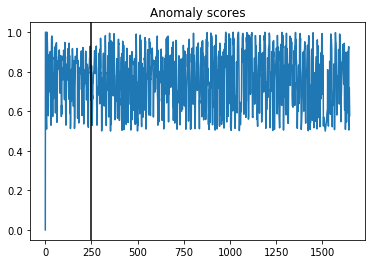

Time:  0.18707609176635742


['anomaly_scores/windowed_gaussian/exchange-2_cpm_results']

In [15]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HOTSAX

In [16]:
# only need one window size

# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)